# Simulate Astronomical Tide using U-tide library: GESLA database


In [1]:
# basic import
import sys
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import linregress

# plot
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px

# custom libs
import utide # https://github.com/wesleybowman/UTide


## GESLA Tide Gauges

In [2]:
df_GESLA = pd.read_pickle('../../../contents/GESLA_Spain.pkl')

In [3]:
fig = px.scatter_mapbox(df_GESLA, lat="Lat", lon="Lon", 
                        hover_data=["Site name", "Start date", "End date", "File name"],
                        color_discrete_sequence=["fuchsia"], zoom=2)
fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0}, 
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])

fig.show()

**Select TG**

In [4]:
Site = 'Santander (Spain)'
file = 'santander-santander-spain_atlantic-ieo'

**Load data**

In [5]:
p_data = op.join(os.getcwd(), '..', '..', '..', 'data', 'Mareografos', 'GESLA_Spain')
file_TG = open(op.join(p_data, file))

txt_TG = file_TG.readlines()

# file content (from text to xarray)
time=[]
obs_SL=[]
QC_flag=[]
ext_flag=[]
for line in range(32, len(txt_TG)):
    
    data = txt_TG[line]    
    time.append(datetime.strptime(data[:19],'%Y/%m/%d %H:%M:%S'))
    obs_SL.append(float(data[32:38]))
    QC_flag.append(int(data[39:40]))
    ext_flag.append(int(data[40:]))

    
ds_TG = xr.Dataset({'SSH': (['time'],  obs_SL[:]),
                    'QC_flag': (['time'], QC_flag[:]),
                    'ext_flag': (['time'], ext_flag[:])},
                     coords={'lon': float(txt_TG[5].split()[2]), 
                             'lat': float(txt_TG[4].split()[2]),
                             'time': time})

# keep trustworthy values
ind = np.where(ds_TG.QC_flag.values==1)
ds_TG = ds_TG.isel(time=ind[0])

ind = np.where(ds_TG.ext_flag.values==1)
ds_TG = ds_TG.isel(time=ind[0])

# round to hour
ds_TG.coords['time'] = ds_TG['time'].dt.round('h')

# check for duplicate values
_, index = np.unique(ds_TG['time'], return_index=True)
ds_TG = ds_TG.isel(time=index)

# remove mean sea level
ds_TG['SL'] = (('time'),  ds_TG['SSH'].values - np.nanmean(ds_TG['SSH'].values))

# TG latitude
lat0 = ds_TG.lat.values


**SL Dataset**

In [6]:
ds_TG

<xarray.Dataset>
Dimensions:   (time: 573475)
Coordinates:
    lon       float64 -3.791
    lat       float64 43.46
  * time      (time) datetime64[ns] 1943-05-08 ... 2010-12-31T23:00:00
Data variables:
    SSH       (time) float64 1.27 1.65 2.24 2.95 3.6 ... 1.7 2.11 2.63 3.23 3.76
    QC_flag   (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    ext_flag  (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    SL        (time) float64 -1.528 -1.148 -0.558 0.152 ... -0.168 0.432 0.962

## SLR removal from Tide

**Calculate SLR using linear regression**

In [7]:
df_t = pd.DataFrame({'time':ds_TG.time.values, 'tide':ds_TG.SL.values}).set_index('time').dropna()

lr_time = np.array(range(len(df_t))) 
slope, intercept, r_value, p_value, std_err = linregress(lr_time, df_t.tide)
slr = intercept + slope * lr_time

**Plot SLR in TG record**

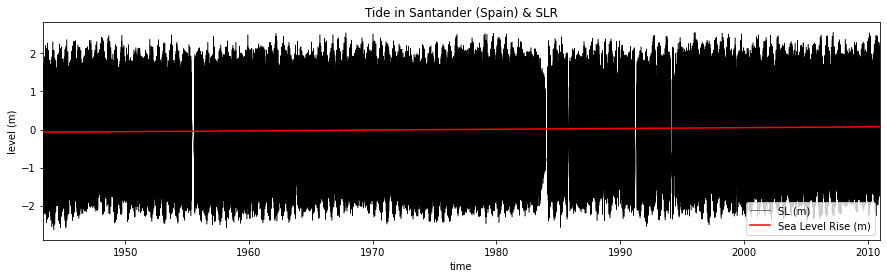

In [8]:
fig, axs = plt.subplots(figsize=(15,4))
plt.plot(
    df_t.index, df_t.tide, '-k',
    linewidth = 0.5, label='SL (m)'
)
plt.plot(df_t.index, slr, '-r', label='Sea Level Rise (m)')
plt.title('Tide in ' + Site + ' & SLR')
plt.xlabel('time')
plt.ylabel('level (m)')

plt.legend()
plt.xlim(df_t.index[0], df_t.index[-1])
plt.show()

**Remove SLR from Tide**

In [9]:
df_t['slr'] = slr
df_t = df_t.reindex(index=ds_TG.time.values, fill_value=np.nan)
ds_TG = ds_TG.assign(SLnSLR = ds_TG.SL - df_t.slr)


## Astronomical Tide - Fitting

**Utide library - reconstruction**

In [10]:
coef = utide.solve(
    matplotlib.dates.date2num(ds_TG.time.values), ds_TG['SLnSLR'].values,
    lat=lat0,
    nodal=True,
    method='ols',
    conf_int='MC',
    trend=False
)

tide_tt = utide.reconstruct(matplotlib.dates.date2num(ds_TG.time.values), coef).h

ds_TG['AT'] = (('time'), tide_tt)


solve: matrix prep ... solution ... done.
prep/calcs ... done.


**Plot SL from TG and and AT from UTide**

Select a time window to plot:

In [11]:
init_date = '1943-06-01'
end_date =  '2010-12-31'

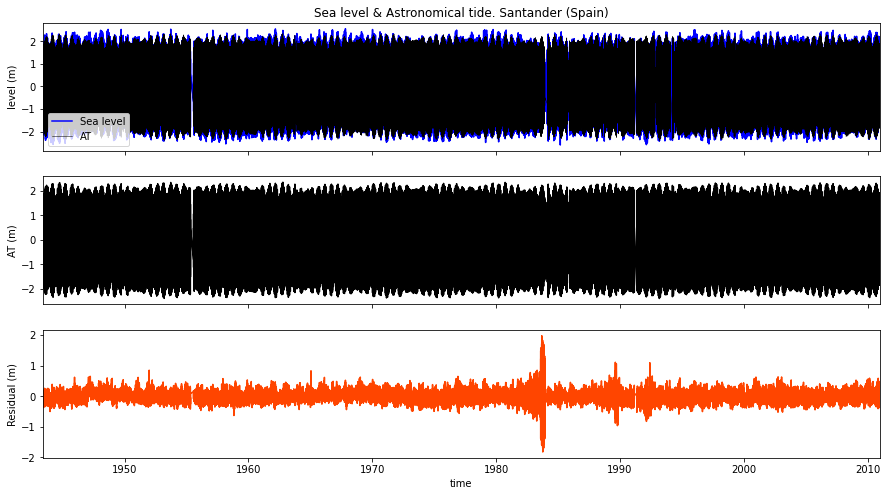

In [12]:
# select time window to plot
ds_TG_z = ds_TG.copy()
ds_TG_z = ds_TG_z.sel(time=slice(init_date, end_date))

# plot full time series
fig, axs = plt.subplots(3, figsize=(15,8), sharex=True)
axs[0].plot(ds_TG_z.time, ds_TG_z.SLnSLR, 'b', linewidth = 1.5, label='Sea level')
axs[0].plot(ds_TG_z.time, ds_TG_z.AT, 'k', linewidth = 0.5, label='AT')
axs[0].set_title('Sea level & Astronomical tide. ' + Site)
axs[0].set_ylabel('level (m)')
axs[0].legend()

axs[1].plot(ds_TG_z.time, ds_TG_z.AT, 'k')
axs[1].set_ylabel('AT (m)')

axs[2].plot(ds_TG_z.time, ds_TG_z.SLnSLR - ds_TG_z.AT, 'orangered')
axs[2].set_xlabel('time')
axs[2].set_ylabel('Residual (m)')

axs[2].set_xlim(np.datetime64(init_date), np.datetime64(end_date))
plt.show()

## Future simulation of AT

**Utide future AT simulation**

In [13]:
# Simulation dates (years)
y1_sim = 1979
y2_sim = 2022

d_pred = np.arange(
    np.datetime64('{0}-01-01'.format(y1_sim)), np.datetime64('{0}-01-01'.format(y2_sim+1)),
    dtype='datetime64[h]'
)
tide_sim = utide.reconstruct(matplotlib.dates.date2num(d_pred), coef).h

prep/calcs ... done.


**Plot future AT**

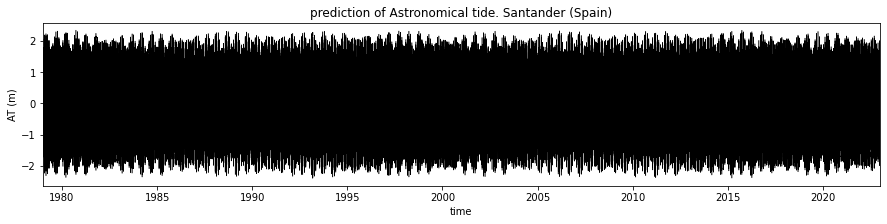

In [14]:
# plot
fig, axs = plt.subplots(figsize=(15,3))
plt.plot(
    d_pred, tide_sim, '-k',
    linewidth = 0.5,
)
plt.title('prediction of Astronomical tide. ' + Site)
plt.xlabel('time')
plt.ylabel('AT (m)')

plt.xlim(d_pred[0], d_pred[-1])
plt.show()